In [1]:
import pandas as pd
import numpy as np

# MATRIZ DE TRANSICIÓN DE ESTADOS PARA EL ENGAGEMENT

df = pd.read_csv("/Users/joshchaidez/Desktop/Globant_Motivation_Prediction/data/data_globant.csv")

# Separar 10% de las personas para testeo
unique_names = df["Name"].unique()
np.random.seed(1111)
test_names = np.random.choice(unique_names, size=int(0.2 * len(unique_names)), replace=False)
train_df = df[~df["Name"].isin(test_names)].reset_index(drop=True)
test_df = df[df["Name"].isin(test_names)].reset_index(drop=True)

# Discretizar
def compute_transition_matrices(
    df,
    numero_estados=10,
    threshold_counts=0,
    threshold_prob=0.05,
    value_col="Engagement",
    id_col="Name",
    sort_cols=None,
):
    if sort_cols is None:
        default_sort = [id_col]
        for c in ("Year", "Month", "Day"):
            if c in df.columns:
                default_sort.append(c)
        sort_cols = default_sort

    # bins y labels
    bins = np.linspace(0, 5, numero_estados + 1)
    labels = bins[1:]  # etiqueta por cada intervalo derecho (ej. 0.5, 1.0, ...)
    
    # trabajar sobre copia para no mutar df original
    tmp = df.copy()
    tmp["Engagement_bin"] = pd.cut(tmp[value_col], bins=bins, labels=labels, include_lowest=True)
    tmp = tmp.sort_values(by=sort_cols)

    # inicializar matriz de conteos
    transition_counts = pd.DataFrame(0, index=labels, columns=labels, dtype=int)

    # contar transiciones
    for _, group in tmp.groupby(id_col):
        states = group["Engagement_bin"].dropna().astype(float).values
        for s1, s2 in zip(states[:-1], states[1:]):
            transition_counts.loc[s1, s2] += 1

    # probabilidades (normalizar por fila)
    transition_prob = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0)

    # aplicar umbral de conteos
    if threshold_counts is not None and threshold_counts > 0:
        transition_counts = transition_counts.where(transition_counts >= threshold_counts, 0)

    # aplicar umbral de probabilidad y renormalizar filas
    if threshold_prob is not None and threshold_prob > 0:
        transition_prob = transition_prob.where(transition_prob >= threshold_prob, 0)
        transition_prob = transition_prob.div(transition_prob.sum(axis=1).replace(0, np.nan), axis=0)

    return transition_counts, transition_prob, bins, labels


In [2]:
# Calcular matrices de transición para 10 y 5 estados con los datos de entrenamiento
transition_counts10, transition_probs10, bins10, labels10 = compute_transition_matrices(
    train_df,
    numero_estados=10,
    threshold_counts=0,
    threshold_prob=0.05,
    value_col="Engagement",
    id_col="Name",
    sort_cols=["Name", "Month", "Day"],
)

transition_probs10

transition_counts5, transition_probs5, bins5, labels5 = compute_transition_matrices(
    train_df,
    numero_estados=5,
    threshold_counts=0,
    threshold_prob=0.05,
    value_col="Engagement",
    id_col="Name",
    sort_cols=["Name", "Month", "Day"],
)

test_df["Engagement_bin_10"] = pd.cut(
    test_df["Engagement"],
    bins=bins10,
    labels=labels10,
    include_lowest=True
)

test_df["Engagement_bin_5"] = pd.cut(
    test_df["Engagement"],
    bins=bins5,
    labels=labels5,
    include_lowest=True
)

transition_probs10, transition_probs5

(          0.5       1.0  1.5       2.0       2.5       3.0       3.5  \
 0.5  0.380952  0.000000  0.0  0.071429  0.159524  0.157143  0.104762   
 1.0  0.000000  0.440367  0.0  0.000000  0.000000  0.440367  0.000000   
 1.5  0.000000  0.000000  0.4  0.000000  0.000000  0.000000  0.133333   
 2.0  0.075650  0.000000  0.0  0.695035  0.158392  0.070922  0.000000   
 2.5  0.000000  0.000000  0.0  0.065236  0.648069  0.200000  0.086695   
 3.0  0.000000  0.000000  0.0  0.000000  0.133086  0.593849  0.273065   
 3.5  0.000000  0.000000  0.0  0.000000  0.000000  0.297530  0.495166   
 4.0  0.000000  0.000000  0.0  0.000000  0.000000  0.066066  0.319069   
 4.5  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.107394   
 5.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
 
           4.0       4.5       5.0  
 0.5  0.126190  0.000000  0.000000  
 1.0  0.119266  0.000000  0.000000  
 1.5  0.133333  0.200000  0.133333  
 2.0  0.000000  0.000000  0.000000  
 2.5  0.00

In [3]:
# Probar las matrices de transición con los datos de testeo
def test_transition_matrix(
    test_df,
    transition_prob,
    state_col="Engagement_bin",
    id_col="Name",
    sort_keys=None,
):
    if sort_keys is None:
        default_sort = [id_col]
        for c in ("Year", "Month", "Day"):
            if c in test_df.columns:
                default_sort.append(c)
        sort_keys = default_sort

    correct = 0
    total = 0

    tmp = test_df.copy()
    tmp = tmp.sort_values(by=sort_keys)

    for _, group in tmp.groupby(id_col):
        states = group[state_col].dropna().astype(float).values
        for s1, s2 in zip(states[:-1], states[1:]):
            if s1 in transition_prob.index and s2 in transition_prob.columns:
                predicted_probs = transition_prob.loc[s1]
                predicted_state = predicted_probs.idxmax()
                if predicted_state == s2:
                    correct += 1
                total += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy

In [4]:
# Acuraccy para 10 y 5 estados
accuracy10 = test_transition_matrix(test_df, transition_probs10, state_col="Engagement_bin_10", id_col="Name", sort_keys= None)
accuracy5 = test_transition_matrix(test_df, transition_probs5, state_col="Engagement_bin_5", id_col="Name", sort_keys= None)

accuracy10, accuracy5

(0.5427675772503359, 0.7227944469323779)

In [5]:
# Test log-likelihood para 10 y 5 estados CHATTTTTTT
def _infer_sort_keys(df, id_col, sort_keys):
    """
    Devuelve la lista de columnas para ordenar, usando la misma lógica
    que test_transition_matrix si sort_keys es None.
    """
    if sort_keys is not None:
        return sort_keys
    
    default_sort = [id_col]
    for c in ("Year", "Month", "Day"):
        if c in df.columns:
            default_sort.append(c)
    return default_sort


def compute_log_likelihood(
    test_df,
    transition_prob,
    state_col="Engagement_bin",
    id_col="Name",
    sort_keys=None,
    eps=1e-12,
):
    sort_keys = _infer_sort_keys(test_df, id_col, sort_keys)

    tmp = test_df.copy()
    tmp = tmp.sort_values(by=sort_keys)

    logL_total = 0.0
    n_transitions = 0

    for _, group in tmp.groupby(id_col):
        states = group[state_col].dropna().astype(float).values
        if len(states) < 2:
            continue

        for s1, s2 in zip(states[:-1], states[1:]):
            # Verificar que existan los estados en la matriz
            if (s1 in transition_prob.index) and (s2 in transition_prob.columns):
                p = transition_prob.loc[s1, s2]
                # Si la prob es 0 o NaN, usamos eps
                if (p is None) or (p <= 0) or np.isnan(p):
                    p = eps
            else:
                # Si la transición no está en la matriz, tratamos como prob muy pequeña
                p = eps

            logL_total += np.log(p)
            n_transitions += 1

    if n_transitions == 0:
        return np.nan, np.nan, np.nan

    logL_avg = logL_total / n_transitions
    perplexity = float(np.exp(-logL_avg))
    return float(logL_total), float(logL_avg), perplexity


In [6]:
# Test log-likelihood para 10 y 5 estados
logL10 = compute_log_likelihood(test_df, transition_probs10, state_col="Engagement_bin_10", id_col="Name", sort_keys=None)
logL5 = compute_log_likelihood(test_df, transition_probs5, state_col="Engagement_bin_5", id_col="Name", sort_keys=None)

logL10, logL5

((-6225.241013854957, -2.787837444628283, 16.245849237811758),
 (-3071.174255031168, -1.3753579288093005, 3.9564926122013704))

In [43]:
import pandas as pd

# Tus resultados
Cadena_10 = (-6225.241013854957, -2.787837444628283, 16.245849237811758)
Cadena_5 = (-3071.174255031168, -1.3753579288093005, 3.9564926122013704)

# Crear tabla
df = pd.DataFrame([
    ["Cadena 10", Cadena_10[0], Cadena_10[1], Cadena_10[2]],
    ["Cadena 5", Cadena_5[0], Cadena_5[1], Cadena_5[2]],
], columns=["Modelo", "LogL_total", "LogL_avg", "Perplexity"])

print(df)


      Modelo   LogL_total  LogL_avg  Perplexity
0  Cadena 10 -6225.241014 -2.787837   16.245849
1   Cadena 5 -3071.174255 -1.375358    3.956493


In [8]:
# Para tres estados calcular accuracy
# Crear matriz de transición para 3 estados
transition_counts3, transition_probs3, bins3, labels3 = compute_transition_matrices(
    train_df,
    numero_estados=3,
    threshold_counts=0,
    threshold_prob=0.05,
    value_col="Engagement",
    id_col="Name",
    sort_cols=["Name", "Month", "Day"],
)

test_df["Engagement_bin_3"] = pd.cut(
    test_df["Engagement"],
    bins=bins3,
    labels=labels3,
    include_lowest=True
)

accuracy3 = test_transition_matrix(test_df, transition_probs3, state_col="Engagement_bin_3", id_col="Name", sort_keys=None)

accuracy3

0.7689207344379758

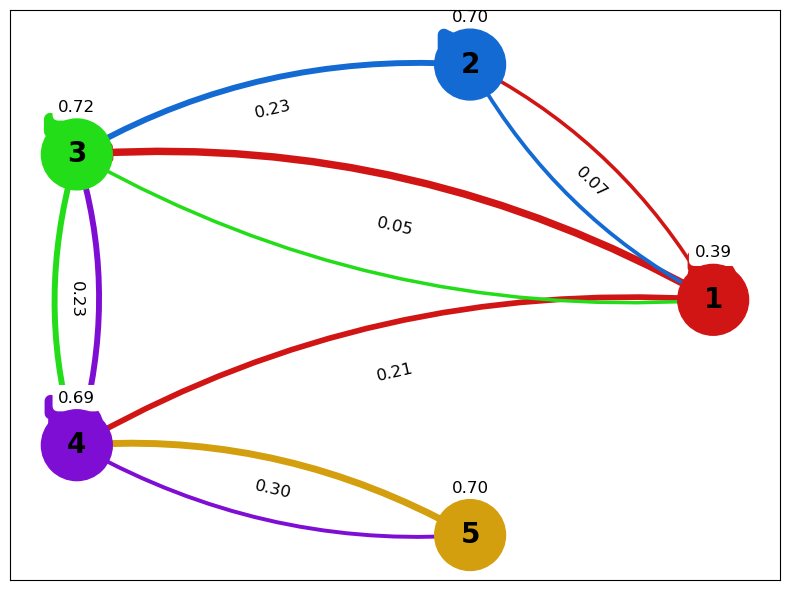

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_markov_chain(P, state_labels=None, node_colors=None,
                      min_prob=0.0, figsize=(8, 6),
                      background_color="transparent"):
    """
    background_color: color de fondo en formato HEX, nombre ("black"), o "transparent"
    """

    P = np.array(P)
    n = P.shape[0]

    if state_labels is None:
        state_labels = list(range(n))
    assert len(state_labels) == n, "state_labels debe tener n elementos"

    if node_colors is None:
        default_colors = ["#ff9999", "#cce5ff", "#c6f3b3", "#f3c6ff",
                          "#ffd699", "#c2f0f0"]
        node_colors = [default_colors[i % len(default_colors)] for i in range(n)]
    assert len(node_colors) == n, "node_colors debe tener n elementos"

    # Crear grafo
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i, label=str(state_labels[i]), color=node_colors[i])

    for i in range(n):
        for j in range(n):
            prob = P[i, j]
            if prob >= min_prob:
                G.add_edge(i, j, weight=prob)

    # Layout visual
    pos = nx.circular_layout(G)

    # --- FIGURA ---
    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Fondo configurable
    if background_color == "transparent":
        ax.set_facecolor((1, 1, 1, 0))   # RGBA transparente
    else:
        ax.set_facecolor(background_color)

    # Dibujar nodos
    node_colors_list = [G.nodes[i]["color"] for i in G.nodes()]
    nx.draw_networkx_nodes(
        G, pos,
        node_size=2600,
        node_color=node_colors_list
    )

    # Etiquetas
    labels_nodes = {i: G.nodes[i]["label"] for i in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels=labels_nodes,
        font_size=20,
        font_weight="bold"
    )

    # Dibujar aristas (color según nodo origen)
    edges = list(G.edges())
    for i in range(n):
        outgoing = [(u, v) for (u, v) in edges if u == i]
        if not outgoing:
            continue

        weights = [G[u][v]["weight"] for (u, v) in outgoing]

        nx.draw_networkx_edges(
            G, pos,
            edgelist=outgoing,
            width=[2 + 10*w for w in weights],
            arrowsize=22,
            edge_color=node_colors[i],
            connectionstyle="arc3,rad=0.15"
        )

    # Etiquetas de aristas con **dos decimales**
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for (u, v) in edges}

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=12,
        label_pos=0.5
    )

    #plt.axis("off")
    plt.tight_layout()
    plt.show()


# ============================ EJEMPLO ============================

P = np.array([
    [0.0711, 0.1743, 0.3674, 0.3872],
    [0.6128, 0.3872, 0.0000, 0.0000],
    [0.2454, 0.3674, 0.3872, 0.0000],
    [0.0711, 0.1743, 0.3674, 0.3872],
])

state_labels = [1, 2, 3, 4, 5]
node_colors = [
    "#D11515",
    "#146AD3",
    "#22DD18",
    "#7E0ED4",
    "#D49F0E",
]

plot_markov_chain(
    transition_probs5,
    state_labels=state_labels,
    node_colors=node_colors,
    min_prob=0.05,
    background_color="transparent"   # ← puedes poner "#FFFFFF" si quieres blanco
)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_markov_chain(P, state_labels=None, node_colors=None,
                      min_prob=0.0, figsize=(8, 6),
                      background_color="transparent"):
    """
    background_color: "transparent" o cualquier HEX (ej. "#A9C37A")
    """

    P = np.array(P)
    n = P.shape[0]

    if state_labels is None:
        state_labels = list(range(n))
    assert len(state_labels) == n

    if node_colors is None:
        default_colors = ["#ff9999", "#cce5ff", "#c6f3b3", "#f3c6ff",
                          "#ffd699", "#c2f0f0"]
        node_colors = [default_colors[i % len(default_colors)] for i in range(n)]
    assert len(node_colors) == n

    # Crear grafo
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i, label=str(state_labels[i]), color=node_colors[i])

    for i in range(n):
        for j in range(n):
            prob = P[i, j]
            if prob >= min_prob:
                G.add_edge(i, j, weight=prob)

    pos = nx.circular_layout(G)

    # ==== FIGURA ====
    if background_color == "transparent":
        fig = plt.figure(figsize=figsize, facecolor=(1,1,1,0))   # transparente real
        ax = plt.gca()
        ax.set_facecolor((1,1,1,0))
    else:
        fig = plt.figure(figsize=figsize, facecolor=background_color)
        ax = plt.gca()
        ax.set_facecolor(background_color)

    # ==== NODOS ====
    nx.draw_networkx_nodes(
        G, pos,
        node_size=2600,
        node_color=[G.nodes[i]["color"] for i in G.nodes()]
    )

    nx.draw_networkx_labels(
        G, pos,
        labels={i: G.nodes[i]["label"] for i in G.nodes()},
        font_size=20,
        font_weight="bold"
    )

    # ==== ARISTAS ====
    edges = list(G.edges())
    for i in range(n):
        outgoing = [(u, v) for (u, v) in edges if u == i]
        if not outgoing:
            continue
        weights = [G[u][v]["weight"] for (u, v) in outgoing]

        nx.draw_networkx_edges(
            G, pos,
            edgelist=outgoing,
            width=[2 + 10*w for w in weights],
            arrowsize=22,
            edge_color=node_colors[i],
            connectionstyle="arc3,rad=0.15"
        )

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={(u, v): f"{G[u][v]['weight']:.2f}" for (u, v) in edges},
        font_size=12
    )

    plt.axis("off")
    plt.show()


node_colors = [
    "#3D348B",  # violeta frío
    "#7678ED",  # azul lavanda
    "#F3722C",  # naranja brillante
    "#F94144",  # rojo vivo
    "#577590",  # azul acero
    "#7209B7",  # morado intenso
    "#4361EE",  # azul eléctrico
    "#4CC9F0",  # celeste vibrante
    "#FF6B6B",  # coral fuerte
    "#FFD166",  # amarillo suave (alto contraste)
]




plot_markov_chain(transition_probs10, state_labels, node_colors, min_prob=0.05, background_color="transparent")



AssertionError: 

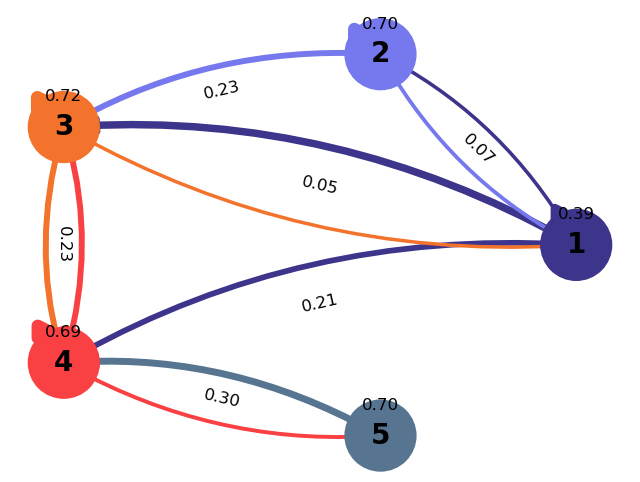

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_markov_chain(P, state_labels=None, node_colors=None,
                      min_prob=0.0, figsize=(8, 6),
                      background_color="transparent"):
    """
    P: matriz de transición n×n
    min_prob: elimina aristas con prob < min_prob
    background_color: "transparent" o HEX (#A9C37A)
    """

    P = np.array(P)
    n = P.shape[0]

    if state_labels is None:
        state_labels = list(range(n))
    assert len(state_labels) == n

    if node_colors is None:
        default_colors = ["#ff9999", "#cce5ff", "#c6f3b3", "#f3c6ff",
                          "#ffd699", "#c2f0f0"]
        node_colors = [default_colors[i % len(default_colors)] for i in range(n)]
    assert len(node_colors) == n

    # ===== Grafo =====
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i, label=str(state_labels[i]), color=node_colors[i])

    for i in range(n):
        for j in range(n):
            prob = P[i, j]
            if prob >= min_prob:
                G.add_edge(i, j, weight=prob)

    pos = nx.circular_layout(G)

    # ===== Figura y fondo =====
    if background_color == "transparent":
        fig = plt.figure(figsize=figsize, facecolor=(1, 1, 1, 0))
        ax = plt.gca()
        ax.set_facecolor((1, 1, 1, 0))
    else:
        fig = plt.figure(figsize=figsize, facecolor=background_color)
        ax = plt.gca()
        ax.set_facecolor(background_color)

    # ===== Nodos =====
    nx.draw_networkx_nodes(
        G, pos,
        node_size=2600,
        node_color=[G.nodes[i]["color"] for i in G.nodes()]
    )

    nx.draw_networkx_labels(
        G, pos,
        labels={i: G.nodes[i]["label"] for i in G.nodes()},
        font_size=20,
        font_weight="bold"
    )

    # ===== Aristas =====
    edges = list(G.edges())
    for i in range(n):
        outgoing = [(u, v) for (u, v) in edges if u == i]
        if not outgoing:
            continue
        weights = [G[u][v]["weight"] for (u, v) in outgoing]

        nx.draw_networkx_edges(
            G, pos,
            edgelist=outgoing,
            width=[2 + 10*w for w in weights],
            arrowsize=22,
            edge_color=node_colors[i],
            connectionstyle="arc3,rad=0.15"
        )

    # ===== Etiquetas de aristas =====
    # 1) No self-loops (usa draw_networkx_edge_labels)
    non_self_edges = [(u, v) for (u, v) in edges if u != v]
    edge_labels_non_self = {
        (u, v): f"{G[u][v]['weight']:.2f}" for (u, v) in non_self_edges
    }

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels_non_self,
        font_size=12,
        label_pos=0.5
    )

    # 2) Self-loops (u == v) → los colocamos a mano
    self_loops = [(u, v) for (u, v) in edges if u == v]
    for u, v in self_loops:
        x, y = pos[u]
        prob = G[u][v]['weight']
        ax.text(
            x, y + 0.15,      # un poco arriba del nodo
            f"{prob:.2f}",
            fontsize=12,
            ha="center",
            va="center"
        )

    plt.axis("off")
    plt.show()

node_colors = [
    "#3D348B",
    "#7678ED",
    "#F3722C",
    "#F94144",
    "#577590",
]

plot_markov_chain(
    transition_probs5,
    state_labels=state_labels,
    node_colors=node_colors,
    min_prob=0.05,
    background_color="transparent"
)

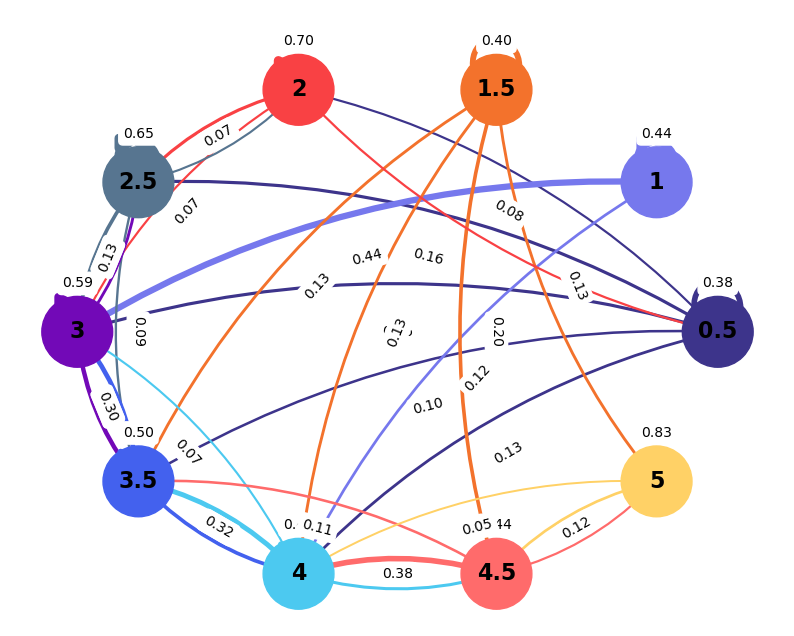

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_markov_chain(P, state_labels=None, node_colors=None,
                      min_prob=0.0, figsize=(10, 8),
                      background_color="transparent"):

    P = np.array(P)
    n = P.shape[0]

    if state_labels is None:
        state_labels = list(range(n))
    assert len(state_labels) == n, "state_labels debe tener n elementos"

    if node_colors is None:
        default_colors = ["#ff9999", "#cce5ff", "#c6f3b3", "#f3c6ff",
                          "#ffd699", "#c2f0f0"]
        node_colors = [default_colors[i % len(default_colors)] for i in range(n)]
    assert len(node_colors) == n, "node_colors debe tener n elementos"

    # Crear grafo
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i, label=str(state_labels[i]), color=node_colors[i])

    for i in range(n):
        for j in range(n):
            prob = P[i, j]
            if prob >= min_prob:
                G.add_edge(i, j, weight=prob)

    pos = nx.circular_layout(G)

    # ==== FIGURA ====
    if background_color == "transparent":
        fig = plt.figure(figsize=figsize, facecolor=(1,1,1,0))
        ax = plt.gca()
        ax.set_facecolor((1,1,1,0))
    else:
        fig = plt.figure(figsize=figsize, facecolor=background_color)
        ax = plt.gca()
        ax.set_facecolor(background_color)

    # ==== NODOS ====
    nx.draw_networkx_nodes(
        G, pos,
        node_size=2600,
        node_color=[G.nodes[i]["color"] for i in G.nodes()]
    )

    nx.draw_networkx_labels(
        G, pos,
        labels={i: G.nodes[i]["label"] for i in G.nodes()},
        font_size=16,
        font_weight="bold"
    )

    # ==== ARISTAS ====
    edges = list(G.edges())

    for i in range(n):
        outgoing = [(u, v) for (u, v) in edges if u == i]
        if not outgoing:
            continue
        weights = [G[u][v]["weight"] for (u, v) in outgoing]

        nx.draw_networkx_edges(
            G, pos,
            edgelist=outgoing,
            width=[1 + 8*w for w in weights],  # un poco más delgado para 10 nodos
            arrowsize=18,
            edge_color=node_colors[i],
            connectionstyle="arc3,rad=0.15"
        )

    # ==== ETIQUETAS DE ARISTAS ====
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={(u, v): f"{G[u][v]['weight']:.2f}" for (u, v) in edges},
        font_size=10
    )

    plt.axis("off")
    plt.show()


# ==============================================
# AQUI ESTÁN TUS 10 COLORES Y 10 LABELS
# ==============================================

state_labels = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

node_colors = [
    "#3D348B",
    "#7678ED",
    "#F3722C",
    "#F94144",
    "#577590",
    "#7209B7",
    "#4361EE",
    "#4CC9F0",
    "#FF6B6B",
    "#FFD166",
]

# EJECUTAR
plot_markov_chain(
    transition_probs10,
    state_labels=state_labels,
    node_colors=node_colors,
    min_prob=0.05,
    background_color="transparent"
)